In [76]:
import time
import ta
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [77]:
data_path = 'data.csv'
data = pd.read_csv(data_path)
data.head()

,date,open,high,low,close,volume
0,2019-11-27 07:00:00,146.00,146.00,146.00,146.00,0.01
1,2019-11-27 08:00:00,125.03,145.01,125.03,133.00,0.08
2,2019-11-27 09:00:00,133.00,133.00,133.00,133.00,0.00
3,2019-11-27 10:00:00,142.20,144.52,142.10,142.62,2832.71
4,2019-11-27 11:00:00,142.70,146.92,142.22,146.58,9079.80


In [78]:
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

In [79]:
# Compute Indicators
def compute_indicators(data):
    data['EMAf'] = ta.trend.ema_indicator(data['close'], 10)
    data['EMAs'] = ta.trend.ema_indicator(data['close'], 30)
    data['Trend'] = ta.trend.sma_indicator(data['close'], 50)
    data['RSI'] = ta.momentum.rsi(data['close'])
    data['ATR'] = ta.volatility.average_true_range(data['high'], data['low'], data['close'], window=14)
    data['CCI'] = ta.trend.cci(data['high'], data['low'], data['close'], window=14)
    data['MACD'] = ta.trend.macd(data['close'])
    data['OBV'] = ta.volume.on_balance_volume(data['close'], data['volume'])
    data['Williams %R'] = ta.momentum.williams_r(data['high'], data['low'], data['close'], lbp=14)
    data['KAMA'] = ta.momentum.kama(data['close'], window=10, pow1=2, pow2=30)
    return data

data = compute_indicators(data)

In [82]:
# Drop NANs
data.dropna(inplace=True) # Remove inplace=True to return the modified DataFrame

data.tail(5)

,date,open,high,low,close,volume,EMAf,EMAs,Trend,RSI,ATR,CCI,MACD,OBV,Williams %R,KAMA
39981,2024-06-19 04:00:00,0.729246,0.729129,0.730450,0.728208,107544.005,0.723780,0.722471,0.723336,0.748469,0.132421,0.658868,0.617793,0.020961,0.871456,0.730729
39982,2024-06-19 05:00:00,0.728222,0.725311,0.728328,0.725989,89662.782,0.725387,0.723423,0.723198,0.706064,0.128071,0.619396,0.624469,0.019656,0.818605,0.731650
39983,2024-06-19 06:00:00,0.726004,0.724221,0.728394,0.728346,40846.363,0.727135,0.724469,0.723073,0.727348,0.122556,0.603646,0.631425,0.020251,0.874762,0.732893
39984,2024-06-19 07:00:00,0.728359,0.724938,0.725026,0.724787,142649.571,0.727910,0.725212,0.722945,0.660930,0.122638,0.577042,0.632505,0.018176,0.789951,0.732845
39985,2024-06-19 08:00:00,0.724799,0.721321,0.724034,0.722098,105010.574,0.728049,0.725731,0.722859,0.614613,0.119356,0.550207,0.629855,0.016648,0.725879,0.732603


In [81]:
# Normalize data
scaler = MinMaxScaler()
columns_to_normalize = ['open','close','high','low','EMAf','EMAs','Trend','RSI','ATR','CCI','MACD','OBV','Williams %R','KAMA']
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])


In [83]:
# Create Sequences
def create_sequences(data, sequence_length):
    xs = []
    ys = []

    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data.iloc[i+sequence_length, 3] # Use iloc to access the element by position
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

sequence_length = 100
features = data[['open', 'close', 'high', 'low', 'EMAf', 'EMAs', 'Trend', 'RSI', 'ATR', 'CCI', 'MACD', 'OBV', 'Williams %R', 'KAMA']] # Use a list to select multiple columns
X, y = create_sequences(features, sequence_length)


In [84]:
# Define LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, len(features.columns))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [85]:
# Splitting the data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [87]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [88]:
# Splitting the data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [89]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/5
996/996 [==============================] - 109s 105ms/step - loss: 6.2719e-04 - val_loss: 7.3533e-05
Epoch 2/5
996/996 [==============================] - 101s 102ms/step - loss: 7.4290e-05 - val_loss: 1.2742e-04
Epoch 3/5
996/996 [==============================] - 106s 106ms/step - loss: 5.6850e-05 - val_loss: 3.2338e-05
Epoch 4/5
996/996 [==============================] - 103s 104ms/step - loss: 5.0977e-05 - val_loss: 2.5459e-05
Epoch 5/5
996/996 [==============================] - 106s 106ms/step - loss: 4.6786e-05 - val_loss: 6.4394e-05


In [90]:
# Make predictions
predictions = model.predict(X_test)

249/249 [==============================] - 10s 38ms/step


In [91]:
# Rescale predictions
predictions_rescaled = scaler.inverse_transform(np.concatenate ([np.zeros((predictions.shape[0], len(features.columns)-1)), predictions], axis=1)) [:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), len(features.columns)-1)), y_test.reshape(-1, 1)], axis=1)) [:, -1]

In [92]:
# Calculate metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

In [93]:
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MAE: {mae}")

MSE: 1413.7582536254538
RMSE: 37.59997677692706
R2: 0.997418701811242
MAE: 32.87539505825293


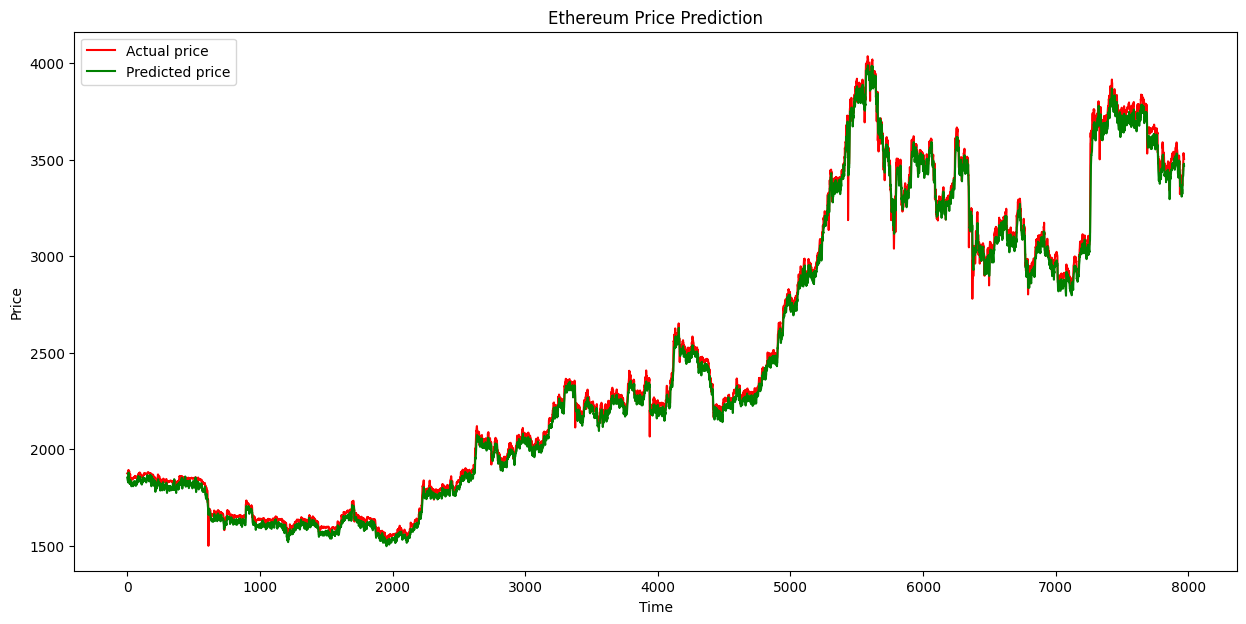

In [94]:
# Plot the data
plt.figure(figsize=(15, 7))
plt.plot(y_test_rescaled, color='red', label='Actual price')
plt.plot(predictions_rescaled, color='green', label='Predicted price')
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()